<a href="https://colab.research.google.com/github/rafabelokurows/similar-countries/blob/main/World_Bank_similarities_between_countries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [257]:
import pandas as pd
import numpy as np
import geopandas
import folium
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
pd.set_option('display.float_format', '{:.3f}'.format)

In [2]:
wb = pd.read_csv('worldbank 2911.csv')

In [3]:
wb.head()

,country,iso2c,iso3c,year,status,lastupdated,NY.GDP.PCAP.KD,SE.XPD.TOTL.GD.ZS,GB.XPD.RSDV.GD.ZS,NY.GDP.TOTL.RT.ZS,...,SI.POV.LMIC,SE.SEC.NENR,VC.IHR.PSRC.P5,SG.GEN.PARL.ZS,region,capital,longitude,latitude,income,lending
0,Afghanistan,AF,AFG,1999,NaN,2022-09-16,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,South Asia,Kabul,69.176,34.523,Low income,IDA
1,Afghanistan,AF,AFG,2018,NaN,2022-09-16,546.743,3.200,NaN,0.891,...,NaN,50.141,6.656,NaN,South Asia,Kabul,69.176,34.523,Low income,IDA
2,Afghanistan,AF,AFG,2019,NaN,2022-09-16,555.139,3.214,NaN,0.693,...,NaN,NaN,NaN,27.869,South Asia,Kabul,69.176,34.523,Low income,IDA
3,Afghanistan,AF,AFG,2018,NaN,2020-09-21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,South Asia,Kabul,69.176,34.523,Low income,IDA
4,Afghanistan,AF,AFG,1998,NaN,2022-09-16,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,South Asia,Kabul,69.176,34.523,Low income,IDA


## Removendo alguns duplicados
".first()" equivalente ao slice(1) do R

In [4]:
wb2 = wb.groupby(["country","year"]).first()

## Contando quantos registros tem por ano e a completeness (%)
25 indicadores - caso buscar mais indicadores, mudar este número

In [5]:
byYear = wb2.groupby(['year']).count()
byYear['complete'] = byYear.iloc[:,4:-7].sum(axis=1)
byYear['completeness'] = (byYear.complete/25)/byYear.iso2c

## Filtrando só os anos que tem completeness > 60%

In [6]:
byYear.sort_values('completeness',ascending=False).query('completeness > 0.6').head()

,iso2c,iso3c,status,lastupdated,NY.GDP.PCAP.KD,SE.XPD.TOTL.GD.ZS,GB.XPD.RSDV.GD.ZS,NY.GDP.TOTL.RT.ZS,GC.XPN.TOTL.GD.ZS,EN.ATM.CO2E.KD.GD,...,VC.IHR.PSRC.P5,SG.GEN.PARL.ZS,region,capital,longitude,latitude,income,lending,complete,completeness
year,,,,,,,,,,,,,,,,,,,,,
2017,267,263,0,268,254,218,123,256,162,234,...,122,238,259,211,211,211,259,259,4779,0.716
2012,267,263,0,268,252,178,113,255,155,233,...,196,236,259,211,211,211,259,259,4497,0.674
2015,267,263,0,268,258,209,129,257,164,236,...,174,237,259,211,211,211,259,259,4456,0.668
2018,267,263,0,268,254,209,117,256,155,234,...,111,239,259,211,211,211,259,259,4454,0.667
2016,267,263,0,268,254,209,116,256,162,234,...,126,240,259,211,211,211,259,259,4368,0.654


## Selecionando dados para a primeira comparação
* Preenchendo NAs
* Selecionando dados de 2017 (apenas alguns países)
* Selecionando apenas colunas de interesse
* Dropando NAs

In [188]:
wb3=wb2.fillna(method='ffill').query('year == 2017').iloc[:,np.r_[4:8,10:18,20:24]].dropna()
wbselected=wb3.query("country in ('Cuba','Belize','Angola','Egypt','Australia','India','South Africa','Kenya','Uganda','Portugal','Brazil','Argentina','United States','Colombia','China','Japan','Canada','Spain','Italy','France','Mexico','Chile','Uruguay','Paraguay')")

## Normalizando dados

In [189]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(wb3), columns=wb3.columns)
df_scaled.head()

,NY.GDP.PCAP.KD,SE.XPD.TOTL.GD.ZS,GB.XPD.RSDV.GD.ZS,NY.GDP.TOTL.RT.ZS,GC.DOD.TOTL.GD.ZS,SH.XPD.CHEX.GD.ZS,SH.XPD.GHED.GD.ZS,NE.CON.PRVT.ZS,NV.IND.TOTL.ZS,MS.MIL.XPND.GD.ZS,GC.TAX.TOTL.GD.ZS,SM.POP.NETM,SP.DYN.LE00.IN,SP.DYN.IMRT.IN,SH.STA.BASS.ZS,SP.POP.TOTL
0,0.024,0.165,0.029,0.032,0.301,0.222,0.217,0.508,0.281,0.053,0.556,0.486,0.804,0.078,0.984,0.000
1,0.023,0.373,0.109,0.319,0.333,0.306,0.343,0.216,0.368,0.284,0.501,0.487,0.748,0.224,0.853,0.006
2,0.065,0.964,0.080,0.000,0.333,0.303,0.336,0.487,0.634,0.319,0.501,0.487,0.765,0.208,0.505,0.000
3,0.224,0.136,0.080,0.000,0.333,0.326,0.382,0.451,0.634,0.319,0.501,0.487,0.765,0.013,1.000,0.000
4,0.015,0.082,0.004,0.367,0.333,0.076,0.098,0.332,0.679,0.120,0.271,0.489,0.251,0.605,0.455,0.004


## Calculando a similaridade com o método do cosseno

In [243]:
similar=cosine_similarity(df_scaled) #calculando a similaridade 
similar.shape #ver formato do NP array
similar[np.diag_indices_from(similar)] = np.NAN
df=pd.DataFrame(data=similar[:,:],index=wb3.index,columns=wb3.index.get_level_values(0))
df['mostSimilar'] = df.idxmax(axis=1)
df['similarity'] = df.max(axis=1)
df2 = df[['mostSimilar','similarity']]

,country,mostSimilar,similarity
country,year,,
Albania,2017,Mauritius,0.992
Algeria,2017,Morocco,0.968
American Samoa,2017,Bolivia,0.955
Andorra,2017,Romania,0.980
Angola,2017,Equatorial Guinea,0.975
...,...,...,...
West Bank and Gaza,2017,Tonga,0.981
World,2017,Middle income,0.961
"Yemen, Rep.",2017,Small states,0.945


In [245]:
tabela = df2.droplevel(1).style.background_gradient(cmap = "BuGn").set_caption("Most similar countries to each other based on key indicators")
tabela.to_html('Similar countries.html')

## Países mais semelhantes ao Brasil

* Selecionar os resultados para o Brasil (menos o próprio Brasil)
* Melt para transformar o dataframe
* Criar estilo de tabela mapeando conforme os valores
* Título e formatação
* Salvando como HTML

In [247]:
brazilData = df.droplevel(1).query("country == 'Brazil'").iloc[:,:-2]
#brazilData.reset_index(level=0,drop=True).melt(ignore_index=False).reset_index().query("country != 'Brazil'").iloc[:,1:].rename(columns={"value": "similarity"}).style.background_gradient(cmap = "BuGn")
tabela2 = brazilData.reset_index(level=0,drop=True).melt(ignore_index=False).reset_index().query("country != 'Brazil'").iloc[:,1:].rename(columns={"value": "similarity"}).sort_values('similarity',ascending=False).style.background_gradient(cmap = "BuGn").set_caption("Most similar countries to Brazil based on key indicators").format({'similarity': "{:.3}"})
tabela2.to_html('Similar countries with Brazil.html')

## Montando um dataframe com nome do país e código ISO (3 letras)


In [252]:
countrieswCode = wb.reset_index(drop=False).loc[:,['country','iso3c']].drop_duplicates()
d = {'country': wb3.reset_index(drop=False).country.unique()}
df1 = pd.DataFrame(data = d )
countries = pd.merge(df1,countrieswCode,how='left',left_on='country',right_on='country') 
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

## Combinando frame dos países com dados

In [253]:
mergedData = brazilData.reset_index(level=0,drop=True).melt(ignore_index=False).reset_index().query("country != 'Brazil'").iloc[:,1:].merge(countries,how='left',left_on='country',right_on='country')#.merge(location,left_on='country',right_on='name').sort_values(by='value',ascending=False).reset_index()
world2 = pd.merge(world,mergedData,how='left',left_on='iso_a3',right_on='iso3c')

## Montando o plot

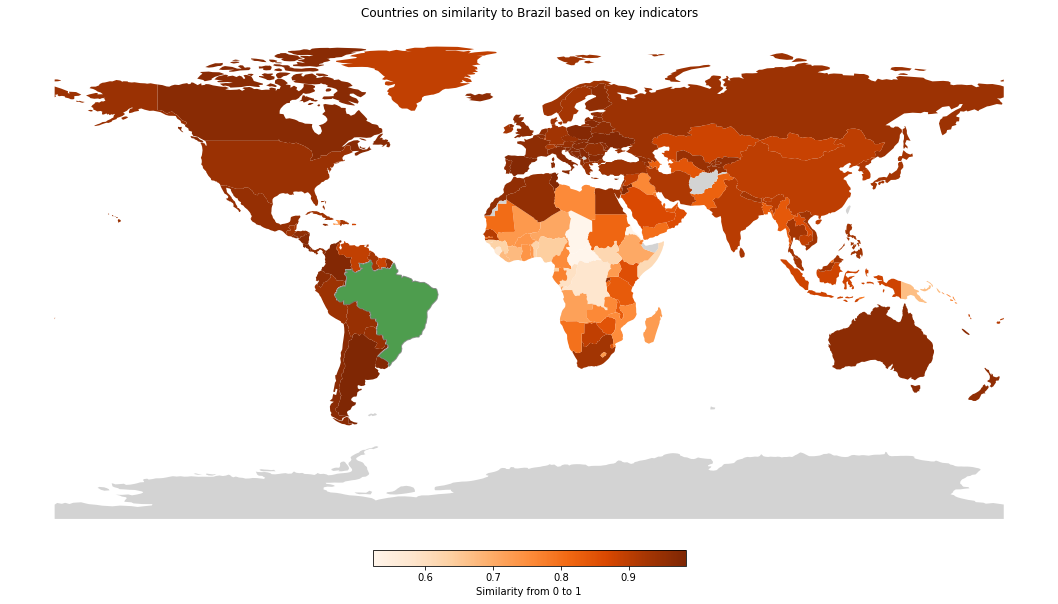

In [291]:
ax1=world2.plot(column='value',figsize=(20, 14),legend=True,cmap='Oranges',missing_kwds={'color': 'lightgrey'},legend_kwds={"orientation": "horizontal", "pad": 0.01,'label': "Similarity from 0 to 1",'shrink': 0.3})
ax1.set_axis_off()
plt.title("Countries on similarity to Brazil based on key indicators", y=1.04)
plt.subplots_adjust(right=0.85)
plt.tick_params(
    axis="both",        # affect both the X and Y
    which="both",       # get rid of both major and minor ticks
    top=False,          # get rid of ticks top/bottom/left/right
    bottom=False,
    left=False,
    right=False,
    labeltop=False,     # get rid of labels top/bottom/left/right
    labelbottom=False,
    labelleft=False,
    labelright=False)
world[world.name == "Brazil"].plot(edgecolor=u'gray', color='forestgreen', alpha=0.75,ax=ax1)
plt.savefig('teste.png',bbox_inches='tight')

In [270]:
world2.explore(column='value',legend=True,cmap='Oranges',tooltip=['name','value'],missing_kwds={'color': 'lightgrey'},
             style_kwds=dict(color="black",weight=3, opacity=0.4),legend_kwds={"orientation": "horizontal", "pad": 0.01,'label': "Similarity from 0 to 1",'shrink': 0.3,'colorbar':'False'})

In [ ]:
#Preenchendo NAs
# wb2 = wb.fillna(method="backfill").fillna(method='ffill')
#Nulos por coluna
# wb2.isnull().sum()
# cols=['country','year','NY.GDP.PCAP.KD']
# wb3.reset_index(drop=True,inplace=True)
#Pivot para transformar o PandasFrame em Wide
# wbWide = wb2.loc[:,cols].pivot(index='country',columns='year',values='NY.GDP.PCAP.KD')
# wbWide.columns = wbWide.columns.map(lambda x: f'GDP_{x+1}')
# wb3.pivot(index='country',columns='year',values='NY.GDP.PCAP.KD')